# Transformer Model - Translator English to Vietnamese - Training

## Import Library

In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.9 MB/s eta 0:00:00


In [2]:
# Necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re,string # For Regular Expressions, string handle
from typing import Iterable, List # For building vocab, yield helper
import math
import time
import random
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Dataset hugging face
from datasets import load_dataset

# Natural language Processing & Initializing Vocabulary
from underthesea import word_tokenize
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


# Building Transformer and Training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence # take the max size and add padding_token to the smaller


## Load Dataset from Hugging Face

IWSLT. (n.d.). mt_eng_vietnamese.py. Hugging Face. Retrieved June 14, 2024, from https://huggingface.co/datasets/IWSLT/mt_eng_vietnamese/blob/main/mt_eng_vietnamese.py

In [3]:
dataset = load_dataset("ncduy/mt-en-vi")
dataset

Generating train split:   0%|          | 0/2884451 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11316 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11225 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 2884451
    })
    validation: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 11316
    })
    test: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 11225
    })
})

- Just take 500.000 rows from train, all for others

In [4]:
df_train = pd.DataFrame(dataset['train'][:200000]).drop(columns=['source'])
df_valid = pd.DataFrame(dataset['validation']).drop(columns=['source'])
df_test = pd.DataFrame(dataset['test']).drop(columns=['source'])

In [5]:
df_train.head(3), df_valid.head(3), df_test.head(3)

(                                           en  \
 0       - Sorry, that question's not on here.   
 1  He wants you to come with him immediately.   
 2        I thought we could use some company.   
 
                                                   vi  
 0    - Xin lỗi, nhưng mà ở đây không có câu hỏi đấy.  
 1          Ông ấy muốn bố đi với ông ấy ngay lập tức  
 2  Tôi nghĩ chúng ta có thể muốn vài người bạn đồ...  ,
                                                   en  \
 0  In August 1764, Bertin permitted the export of...   
 1  Homeless women used to be invisible to me but ...   
 2  Pumping water site for artificial infiltration...   
 
                                                   vi  
 0  Tháng 8 năm 1764, Bertin lại cho phép xuất khẩ...  
 1  Tôi từng không hề để ý đến những người phụ nữ ...  
 2        Bơm nước cho thấm nhân tạo ở quận Sojovice.  ,
                                                   en  \
 0  And what I think the world needs now is more c...   
 1  

- So:

The training data has 500,000 rows.

The validation data has 11,316 rows.

The test data has 11225 rows.

## Data Preprocessing

- Check Missing values

In [6]:
print("Training Data: ")
print(df_train.isna().sum())

print("Validation Data: ")
print(df_valid.isna().sum())

print("Test Data: ")
print(df_test.isna().sum())

Training Data: 
en    0
vi    0
dtype: int64
Validation Data: 
en    0
vi    0
dtype: int64
Test Data: 
en    0
vi    0
dtype: int64


- Sentences cleaning: some sentences will have a few mini errors. More than one ' ' or having special symbols for example.

In [7]:
def SentenceCleaning(df):

    # Cleaning
    df['en'] = df['en'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # Make a new trans without punctuation
    df['vi'] = df['vi'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    df['en'] = df['en'].str.lower() # To easy and smaller vocab we should lower 
    df['vi'] = df['vi'].str.lower()

    df['en'] = df['en'].str.strip() # clear spaces in the beginning and end of sentence
    df['vi'] = df['vi'].str.strip()

    df['en'] = df['en'].apply(lambda x: re.sub('\s+',' ',x)) # replace '       ' to ' ' for example
    df['vi'] = df['vi'].apply(lambda x: re.sub('\s+',' ',x))

    return df
    

In [8]:
df_train = SentenceCleaning(df_train)
df_valid = SentenceCleaning(df_valid)
df_test = SentenceCleaning(df_test)

In [9]:
df_train.head(10)

,en,vi
0,sorry that questions not on here,xin lỗi nhưng mà ở đây không có câu hỏi đấy
1,he wants you to come with him immediately,ông ấy muốn bố đi với ông ấy ngay lập tức
2,i thought we could use some company,tôi nghĩ chúng ta có thể muốn vài người bạn đồ...
3,it was founded in 2008 by this anonymous progr...,nó được sáng lập vào năm 2008 bởi một lập trìn...
4,with both of these methods no two prints are e...,với cả hai phương pháp không có hai bản in nào...
5,from these contexts was born an installation i...,từ những tình huống này một bố trí không gian ...
6,i have lived to see something which i never ex...,ta đã sống để thấy điều ta không bao giờ mong đợi
7,it is the model for all future relationships w...,đó là mô hình cho tất cả các mối quan hệ trong...
8,welcome him as your brother,chào mừng nó như anh em của các con
9,so biologists can make all the mutant fruit fl...,vậy các nhà sinh vật học có thể biến đổi gene ...


- Check for rows that contain words that are not within the range of the source and target languages

Both English and Vietnamese use the Latin alphabet, but Vietnamese adds diacritics to create special characters to represent different sounds. To filter out lines with words that do not belong to English and Vietnamese, we use appropriate regular expressions

In [10]:
def language_filter(df):
    def is_valid_language_sentence(sentence):
        pattern = re.compile(r'^[A-Za-zÀ-ỹà-ỹ\s]*$')
        return bool(pattern.match(sentence))
    filtered_df = df[df['en'].apply(is_valid_language_sentence) & df['vi'].apply(is_valid_language_sentence)]
    return filtered_df

In [11]:
df_train_filter = language_filter(df_train)
df_valid_filter = language_filter(df_valid)
df_test_filter = language_filter(df_test)

print(f'Train: before: {df_train.shape[0]} - after: {df_train_filter.shape[0]}')
print(f'valid: before: {df_valid.shape[0]} - after: {df_valid_filter.shape[0]}')
print(f'test: before: {df_test.shape[0]} - after: {df_test_filter.shape[0]}')

Train: before: 200000 - after: 156398
valid: before: 11316 - after: 8596
test: before: 11225 - after: 8560


As we see, lots of rows have some words which are unrelated to its language! (20% - 30% data)

If we use the raw dataframe to create the vocabulary, the size will be very large leading to 'Issue 03: CUDA out of memory'.

How about using df_filter? Smaller size vocabulary will be created. But we will ignore correct words in invalid lines containing incorrect words and make the model ineffective.

**My solution:** With the invalid rows, just remove the wrong words and use another words and valid words in valid rows to initialize a vocabulary. This will keep important word and minimize the unrelated words in vocabulary. (Reuslt: the size of the vocabulary has been halved)

In [12]:
def sentence_tomake_vocab(sentence):
    sentence = re.sub(r'^[A-Za-zÀ-ỹà-ỹ\s]*$', '', sentence)
    return sentence

df_tomake_vocab = pd.concat([df_train, df_valid], ignore_index=True)
df_tomake_vocab['en'] = df_tomake_vocab['en'].apply(sentence_tomake_vocab)
df_tomake_vocab['vi'] = df_tomake_vocab['vi'].apply(sentence_tomake_vocab)
df_tomake_vocab = SentenceCleaning(df_tomake_vocab)

- Building **Tokenizer** and **Vocabulary**

With English - The most popular international language, **'torchtext.data.utils.get_tokenizer'** support the default language with 'en' - English. But Vietnamese has not already been supported.

But get_tokenizer allow us to transmission the function word_token returning a list to get_tokenizer. Then, the problems lead to what framework supports to Vietnamese. It must be Underthesea - the best support to Vietnamese in NLP

You can read **[torchtext - doc](https://pytorch.org/text/stable/data_utils.html)**!

In [13]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

- **Tokenizer**

In [14]:
tokenizer = {}

# Tokenizer for English
tokenizer[SRC_LANGUAGE] = get_tokenizer('basic_english')

# Tokenizer for Vietnamese
# Need help with Underthesea
def vi_tokenize(sentence):
    return word_tokenize(sentence) # word_tokenize from undersea supporting vietnamese
tokenizer[TGT_LANGUAGE] = get_tokenizer(vi_tokenize)

In [15]:
print(tokenizer[SRC_LANGUAGE]("hello can you help me"))
print(tokenizer[TGT_LANGUAGE]("xin chào bạn có thể giúp tôi không"))

['hello', 'can', 'you', 'help', 'me']
['xin', 'chào bạn', 'có thể', 'giúp', 'tôi', 'không']


We can clearly see that this Tokenizer will generate dictionaries with words and not characters as we tested before and failed.

- **Vocabulary**

Build a Vocab from an iterator.
```python
torchtext.vocab.build_vocab_from_iterator(iterator: Iterable, min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True, max_tokens: Optional[int] = None) → Vocab
```

> - Parameters:

**iterator** – Iterator used to build Vocab. Must **yield** list or iterator of tokens.

**min_freq** – The minimum frequency needed to include a token in the vocabulary.

**specials** – Special symbols to add. The order of supplied tokens will be preserved.

**special_first** – Indicates whether to insert symbols at the beginning or at the end.

**max_tokens** – If provided, creates the vocab from the max_tokens - len(specials) most frequent tokens.



In [16]:
def yield_token_helper(iterator : Iterable, language: str) -> List[str]:
    for num_iter, sample_iter in iterator:
        yield tokenizer[language](sample_iter[language])

In [17]:
# Special Symbols
UNKNOWN_TOKEN, PADDING_TOKEN, START_TOKEN, END_TOKEN = '<unk>', '<pad>', '<bos>', '<eos>'
UNKNOWN_IDX, PADDING_IDX, START_IDX, END_IDX = 0,1,2,3

In [18]:
# Building vocab
def vocab_building(df):
    vocab = {}
    for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
        iterator = df.iterrows()
        vocab[language] = build_vocab_from_iterator(
            iterator=yield_token_helper(iterator, language),
            min_freq=1,
            specials=[UNKNOWN_TOKEN, PADDING_TOKEN, START_TOKEN, END_TOKEN], # List special symbols
            special_first=True
        )

    for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
        vocab[language].set_default_index(UNKNOWN_IDX)
    return vocab

In [19]:
vocabulary = vocab_building(df_tomake_vocab)
vocabulary

{'en': Vocab(), 'vi': Vocab()}

In [20]:
vocabulary[SRC_LANGUAGE]['who']

51

In [21]:
vocabulary[TGT_LANGUAGE]['nào']

222

## Building Complete Model 

- Use some of the classes, functions available in torch.nn. If you want a program from scratch, please check ModelBuilding.ipynb
- Input/Output shape: (seq, batch, feature). We can change this by this parameter:

```python 
batch_first (bool)
``` 


– If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).

In [22]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size:int, d_model:int):
        super(TokenEmbedding, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    
    def forward(self, tokens: torch.Tensor):
        return self.embedding_layer(tokens.long()) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, max_length_seq:int, d_model:int, dropout_rate:float):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, d_model, 2)* math.log(10000) / d_model)
        pos = torch.arange(0, max_length_seq).reshape(max_length_seq, 1)
        PE = torch.zeros((max_length_seq, d_model))
        PE[:, 0::2] = torch.sin(pos * den)
        PE[:, 1::2] = torch.cos(pos * den)
        PE = PE.unsqueeze(-2)
        self.register_buffer("PE", PE)
        self.dropout_layer = nn.Dropout(dropout_rate)
        
    def forward(self, token_embedding: torch.Tensor):
        return self.dropout_layer(token_embedding + self.PE[:token_embedding.size(0), :])
    
class TransformerModel(nn.Module):
    def __init__(self,
                 src_vocab_size:int,
                 tgt_vocab_size:int,
                 d_model:int,
                 nhead:int,
                 num_encoder_layers:int,
                 num_decoder_layers:int,
                 dim_feedforward:int,
                 dropout:float,
                 max_length_seq=20000):
        super(TransformerModel,self).__init__()
        # Input Preprocessing
        self.input_token_embedding = TokenEmbedding(vocab_size=src_vocab_size,d_model=d_model)
        
        # Output Preprocessing
        self.output_token_embedding = TokenEmbedding(vocab_size=tgt_vocab_size,d_model=d_model)
        
        # Positional Encoding
        self.positional_encoding = PositionalEncoding(max_length_seq=max_length_seq,d_model=d_model,dropout_rate=dropout)
        
        # Transformer Architecture with Encoder & Decoder (available nn.Transformer) 
        self.transformer = nn.Transformer(d_model=d_model,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        
        # Linear Layer
        self.generator = nn.Linear(d_model, tgt_vocab_size)
    
    def forward(self,
                src: torch.Tensor,
                tgt: torch.Tensor,
                src_mask: torch.Tensor,
                tgt_mask: torch.Tensor,
                src_key_padding_mask: torch.Tensor,
                tgt_key_padding_mask: torch.Tensor,
                memory_key_padding_mask: torch.Tensor):
        
        # Pre-processing
        src_embedding = self.positional_encoding(self.input_token_embedding(src))
        tgt_embedding = self.positional_encoding(self.output_token_embedding(tgt))
        
        output = self.transformer(src_embedding, tgt_embedding, src_mask, tgt_mask, None, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask)
        return self.generator(output)
    
    
    def encode(self, src: torch.Tensor, src_mask: torch.Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.input_token_embedding(src)), src_mask)

    def decode(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: torch.Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.output_token_embedding(tgt)), memory,
                          tgt_mask)
        

In [45]:
class SupportTransformer:
    
    def __init__(self,
                 device,
                 src_language:str,
                 tgt_language:str,
                 start_idx:int,
                 end_idx:int,
                 pad_idx:int,
                 unk_idx:int,
                 tokenizer,
                 vocabulary):
        self.device = device
        self.src_language = src_language
        self.tgt_language = tgt_language
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary
    
    def generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones((size, size), device=self.device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def create_mask(self, src, tgt):
        src_seq_len = src.shape[0]
        tgt_seq_len = tgt.shape[0]

        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)
        src_mask = torch.zeros((src_seq_len, src_seq_len),device=self.device).type(torch.bool)

        src_padding_mask = (src == self.pad_idx).transpose(0, 1)
        tgt_padding_mask = (tgt == self.pad_idx).transpose(0, 1)
        return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    
    def preprocessing_sentece(self, sentence:str, options=True): # True for src, False for tgt
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        sentence = sentence.lower()
        sentence = sentence.strip()
        sentence = re.sub('\s+', ' ', sentence)
        
        
        lang = self.src_language if options else self.tgt_language
        # Tokenizer
        tokens = self.tokenizer[lang](sentence.rstrip("\n"))
        # vocabulary: text -> number
        tokens_idx = self.vocabulary[lang](tokens)
        # Add start_token, end_token and append
        return torch.cat((torch.tensor([self.start_idx]),
                                      torch.tensor(tokens_idx),
                                      torch.tensor([self.end_idx])))
        
    
    def get_batch(self, df):
        return list(zip(df[self.src_language], df[self.tgt_language]))
    
    def preprocessing_batch(self,batch):
        src_out, tgt_out = [], []
        
        for src_data, tgt_data in batch:
            src_out.append(self.preprocessing_sentece(src_data,options=True))
            tgt_out.append(self.preprocessing_sentece(tgt_data,options=False))
            
        src_batch, tgt_batch = pad_sequence(src_out, padding_value=self.pad_idx), pad_sequence(tgt_out, padding_value=self.pad_idx)
    
        return src_batch, tgt_batch
    
    def evaluate(self, model, loss_func, df_valid, batch_size=30, accumulation_steps=5):
        model.eval()
        valid_loss = 0 
        valid_batch = self.get_batch(df_valid)
        valid_dataloader = DataLoader(valid_batch, batch_size=batch_size, collate_fn=self.preprocessing_batch)
        for index, (src, tgt) in enumerate(valid_dataloader):
            src = src.to(self.device)
            tgt = tgt.to(self.device)
            
            tgt_input = tgt[:-1, :] # Without the last word
            
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt_input)
            
            # predictions
            predictions = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            
            tgt_out = tgt[1:, :]
            # Loss
            loss = loss_func(predictions.reshape(-1, predictions.shape[-1]), tgt_out.reshape(-1))
            loss = loss / accumulation_steps
            valid_loss += loss.item()
            
        return valid_loss / len(valid_dataloader)
            
        
    
    def train(self, model, optimizer, loss_func, df_train, batch_size = 30, accumulation_steps = 5):
        model.train()
        
        train_loss = 0
        train_batch = self.get_batch(df_train)
        train_dataloader = DataLoader(train_batch, batch_size=batch_size, collate_fn=self.preprocessing_batch)
        
        # Reset grad
        optimizer.zero_grad()
        for index, (src, tgt) in enumerate(train_dataloader):
            src = src.to(self.device)
            tgt = tgt.to(self.device)
            
            tgt_input = tgt[:-1, :] # Without the last word
            
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt_input)
            
            # predictions
            predictions = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            
            tgt_out = tgt[1:, :]
            # Loss
            loss = loss_func(predictions.reshape(-1, predictions.shape[-1]), tgt_out.reshape(-1))
            loss = loss / accumulation_steps
            loss.backward()
            
            if (index+1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad() # Reset gradients tensor 
            train_loss += loss.item()
            
        return train_loss / len(train_dataloader)
    
    def generate(self, model, src_sentence):
        start_symbol = self.start_idx
        src = self.preprocessing_sentece(src_sentence, True).view(-1, 1)
        max_len = src.shape[0]
        src_mask = (torch.zeros(max_len, max_len)).type(torch.bool)
        
        src = src.to(self.device)
        src_mask = src_mask.to(self.device)

        memory = model.encode(src, src_mask)
        ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(self.device)
        for i in range(max_len-1):
            memory = memory.to(self.device)
            tgt_mask = (self.generate_square_subsequent_mask(ys.size(0))
                        .type(torch.bool)).to(self.device)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1) # Greedy
            next_word = next_word.item()

            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
            if next_word == self.end_idx:
                break

        return " ".join(
            self.vocabulary[self.tgt_language].lookup_tokens(list(ys.cpu().numpy()))
        ).replace(
            self.vocabulary[self.tgt_language].lookup_token(self.start_idx), ""
        ).replace(
            self.vocabulary[self.tgt_language].lookup_token(self.end_idx), ""
        ).strip()
    
    def completely_generate(self, model, src_sentence):
        start_symbol = self.start_idx
        src = self.preprocessing_sentece(src_sentence, True)
        
        src = src.view(-1, 1)
        max_len = src.shape[0]
        src_mask = (torch.zeros(max_len, max_len)).type(torch.bool)
        
        src = src.to(self.device)
        src_mask = src_mask.to(self.device)

        memory = model.encode(src, src_mask)
        ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(self.device)
        for i in range(max_len-1):
            memory = memory.to(self.device)
            tgt_mask = (self.generate_square_subsequent_mask(ys.size(0))
                        .type(torch.bool)).to(self.device)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1) # Greedy
            next_word = next_word.item()

            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
            if next_word == self.end_idx:
                break

        # Find unkown words in tgt generate
        tgt_unk_indexes = torch.nonzero(ys == self.unk_idx).squeeze().tolist()
        
        output_list = self.vocabulary[self.tgt_language].lookup_tokens(list(ys.cpu().numpy()))
        src_tokens = self.tokenizer[self.src_language](src_sentence)
        for index in tgt_unk_indexes:
            if index[0]-1 < len(src_tokens):
                output_list[index[0]] = src_tokens[index[0]-1]

        
        return " ".join(
            output_list
        ).replace(
            self.vocabulary[self.tgt_language].lookup_token(self.start_idx), ""
        ).replace(
            self.vocabulary[self.tgt_language].lookup_token(self.end_idx), ""
        ).strip()
    
    def training(self, model, optimizer, loss_func, earlystopping, df_train, df_valid, epochs=5, batch_size = 30, accumulation_steps = 5, custom_test=None):
        history = {'train_loss': [], 'valid_loss': []}
        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}: " + ("-" * 80))
            start = time.time()
            train_loss = self.train(model, optimizer, loss_func, df_train, batch_size, accumulation_steps)
            history['train_loss'].append(train_loss)
            valid_loss = self.evaluate(model, loss_func, df_valid, batch_size)
            history['valid_loss'].append(valid_loss)
            print(f"- Train loss: {train_loss:.3f} - Valid loss: {valid_loss:.3f} - Time training: {(time.time() - start):.3f}")
            
            # custom_test
            if custom_test != None:
                print(f"Input '{self.src_language}': {custom_test}")
                print(f"Output '{self.tgt_language}' generate: {self.generate(model, custom_test)}",end="\n\n")
            else:
                print("\n\n")
                
            # EarylyStopping
            earlystopping(train_loss, valid_loss)
            if earlystopping.early_stop:
                print("Early Stopping active!")
                break
        return history

## Setup Model

- **Config**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_vocab_size = len(vocabulary[SRC_LANGUAGE])
tgt_vocab_size = len(vocabulary[TGT_LANGUAGE])
d_model = 512
nhead = 8 # d_model must be divisible by nhead
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 512
dropout = 0.1
EPOCHS = 5
BATCH_SIZE = 30

- **Model, Optimizer, EarlyStopping and Loss**

In [25]:
model = TransformerModel(src_vocab_size=src_vocab_size,
                         tgt_vocab_size=tgt_vocab_size,
                         d_model=d_model,
                         nhead=nhead,
                         num_encoder_layers=num_encoder_layers,
                         num_decoder_layers=num_decoder_layers,
                         dim_feedforward=dim_feedforward,
                         dropout=dropout)
model = model.to(device)
model

TransformerModel(
  (input_token_embedding): TokenEmbedding(
    (embedding_layer): Embedding(72982, 512)
  )
  (output_token_embedding): TokenEmbedding(
    (embedding_layer): Embedding(71795, 512)
  )
  (positional_encoding): PositionalEncoding(
    (dropout_layer): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
      

In [26]:
# Initializing the weights of paramaters which have more than a dimension
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
# Loss
loss_func = nn.CrossEntropyLoss(ignore_index=PADDING_IDX)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# EarlyStopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
earlystopping  = EarlyStopping(tolerance=5, min_delta=0.1)

## Training Model

In [27]:
sp = SupportTransformer(device=device,
                        src_language=SRC_LANGUAGE,
                        tgt_language=TGT_LANGUAGE,
                        start_idx=START_IDX,
                        end_idx=END_IDX,
                        pad_idx=PADDING_IDX,
                        unk_idx=UNKNOWN_IDX,
                        tokenizer=tokenizer,
                        vocabulary=vocabulary
                       )
 
history = sp.training(model=model,
            optimizer=optimizer,
            loss_func=loss_func,
            earlystopping=earlystopping,
            df_train=df_train,
            df_valid=df_valid,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            accumulation_steps=5,
            custom_test="i like you")

Epoch 1: --------------------------------------------------------------------------------
- Train loss: 1.229 - Valid loss: 1.016 - Time training: 781.452
Input 'en': i like you
Output 'vi' generate: tôi như anh

Epoch 2: --------------------------------------------------------------------------------
- Train loss: 0.962 - Valid loss: 0.853 - Time training: 780.643
Input 'en': i like you
Output 'vi' generate: tôi thích anh

Epoch 3: --------------------------------------------------------------------------------
- Train loss: 0.835 - Valid loss: 0.762 - Time training: 780.661
Input 'en': i like you
Output 'vi' generate: tôi thích anh

Epoch 4: --------------------------------------------------------------------------------
- Train loss: 0.751 - Valid loss: 0.708 - Time training: 779.293
Input 'en': i like you
Output 'vi' generate: tôi thích anh

Epoch 5: --------------------------------------------------------------------------------
- Train loss: 0.691 - Valid loss: 0.677 - Time train

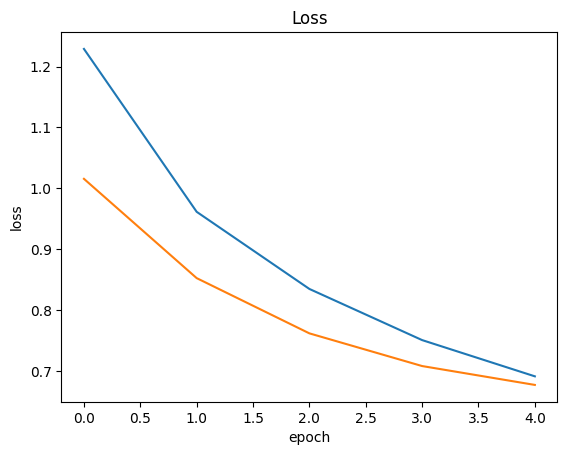

In [28]:
plt.plot(history['train_loss'], label = "train loss")
plt.plot(history['valid_loss'], label = "valid loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss');

## Testing

In [29]:
def testing_generate(df, model, support:SupportTransformer, number=20,shuffle=False):
    indexes = random.sample(range(len(df) + 1), number)
    for index in indexes:
        print('-' * 80,end='\n\n')
        print(f"Input '{support.src_language}': {df.iloc[index][support.src_language]}")
        print(f"True Output '{support.tgt_language}': {df.iloc[index][support.tgt_language]}")
        print(f"Generate Output '{support.tgt_language}': {support.generate(model,df.iloc[index][support.src_language])}",end="\n\n")
    

In [30]:
testing_generate(df_test, model, sp, number=20, shuffle=True)

--------------------------------------------------------------------------------

Input 'en': you heard and were intrigued
True Output 'vi': anh đã nghe và anh tò mò
Generate Output 'vi': anh nghe và chúng tôi đang <unk>

--------------------------------------------------------------------------------

Input 'en': im sorry i made him late
True Output 'vi': tôi xin lỗi tôi khiến anh ấy bị muộn
Generate Output 'vi': tôi xin lỗi tôi đã làm ông ấy

--------------------------------------------------------------------------------

Input 'en': it took much courage to be here
True Output 'vi': phải lấy rất nhiều can đảm để đến nơi đây
Generate Output 'vi': nó đã rất dũng cảm đến đây

--------------------------------------------------------------------------------

Input 'en': the script was researched and written by filmmaker s leigh savidge and radio veteran alan wenkus who worked closely with eazyes widow tomica woodswright
True Output 'vi': kịch bản được nghiên cứu và viết bởi nhà làm phim 

## Save model & support

In [31]:
MODEL_PATH = './model/translator_EnVi.pth'
OPTIMIZER_PATH = './model/optimizer.pth'
SUPPORT_PATH = './model/support_transformer.pkl'

In [32]:
os.makedirs('./model/', exist_ok=True)

# Save model state_dict
torch.save(model.state_dict(), MODEL_PATH)

# Save optimizer state_dict
torch.save(optimizer.state_dict(), OPTIMIZER_PATH)

In [49]:
# Save helper
with open(SUPPORT_PATH, 'wb') as f:
    pickle.dump(sp, f)

## Complete Generative Translator 

In [50]:
# Input Here
sentence = "Hey, do you know who i am?"
sp.completely_generate(model, sentence)

'này anh biết tôi là ai'

In [51]:
sentence = "Transformer is the best model for translating."
sp.completely_generate(model, sentence)

'transformer là mô hình tốt nhất cho thấy .'

## References

PyTorch. (n.d.). PyTorch. Retrieved June 15, 2024, from https://pytorch.org/docs/stable/index.html

PyTorch. (n.d.). PyTorch text. Retrieved June 15, 2024, from https://pytorch.org/text/stable/

Nguyen, H. (n.d.). English to Vietnamese with Transformer. Kaggle. Retrieved June 15, 2024, from https://www.kaggle.com/code/huhuyngun/english-to-vietnamese-with-transformer